# PLEQUE vs raw reconstruction

In this notebook, we demonstrate that PLEQUE is better than raw reconstruction at everything.

In [1]:
%pylab inline 

#Setting autoreload 2 means to "reload all modules (except those excluded by %aimport)
#    every time before executing the Python code typed".
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pleque.io import _geqdsk as eqdsktool 
from pleque.io.readers import read_geqdsk
from pleque.utils.plotting import *
from pleque import Equilibrium
from pleque.tests.utils import get_test_equilibria_filenames, load_testing_equilibrium

## Load a testing equilibrium
Several test equilibria come shipped with PLEQUE. Their location is:

In [3]:
gfiles = get_test_equilibria_filenames()
gfiles

['/home/katerina/Plocha/Výzkum/pleque/pleque/resources/baseline_eqdsk',
 '/home/katerina/Plocha/Výzkum/pleque/pleque/resources/scenario_1_baseline_upward_eqdsk',
 '/home/katerina/Plocha/Výzkum/pleque/pleque/resources/DoubleNull_eqdsk',
 '/home/katerina/Plocha/Výzkum/pleque/pleque/resources/g13127.1050',
 '/home/katerina/Plocha/Výzkum/pleque/pleque/resources/14068@1130_2kA_modified_triang.gfile',
 '/home/katerina/Plocha/Výzkum/pleque/pleque/resources/g15349.1120',
 '/home/katerina/Plocha/Výzkum/pleque/pleque/resources/shot8078_jorek_data.nc']

### Load EFIT output directly

Here the test equilibrium is directly loaded and stored in the variable `eq_efit`.

In [4]:
test_case_number = 5

with open(gfiles[test_case_number], 'r') as f:
    eq_efit = eqdsktool.read(f)
eq_efit.keys()

  nx = 33, ny = 33
361 231


dict_keys(['nx', 'ny', 'rdim', 'zdim', 'rcentr', 'rleft', 'zmid', 'rmagx', 'zmagx', 'simagx', 'sibdry', 'bcentr', 'cpasma', 'F', 'pres', 'FFprime', 'pprime', 'psi', 'q', 'rbdry', 'zbdry', 'rlim', 'zlim'])

### Load equilibrium using PLEQUE

PLEQUE also loads EFIT output, but it wraps it in the `Equilibrium` class and stores it in the variable `eq`.


In [5]:
def save_it(*args,**kwargs):
    pass

  nx = 33, ny = 33
361 231
---------------------------------
Equilibrium module initialization
---------------------------------
--- Generate 2D spline ---
--- Looking for critical points ---
--- Recognizing equilibrium type ---
>> X-point plasma found.
--- Looking for LCFS: ---
Relative LCFS error: 2.452534050621385e-12
--- Generate 1D splines ---
--- Mapping midplane to psi_n ---
--- Mapping pressure and f func to psi_n ---


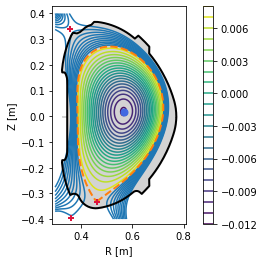

In [6]:
#Load equilibrium stored in the EQDSK format
eq = read_geqdsk(gfiles[test_case_number])

#Plot basic overview of the equilibrium
plt.figure()
eq._plot_overview()

#Plot X-points
plot_extremes(eq, markeredgewidth=2)

## PLEQUE vs raw reconstruction: spatial resolution near the X-point

EFIT output ($\Psi$, $j$ etc.) is given on a rectangular grid:

In [7]:
r_axis = np.linspace(eq_efit["rleft"], eq_efit["rleft"] + eq_efit["rdim"], eq_efit["nx"])
z_axis = np.linspace(eq_efit["zmid"] - eq_efit["zdim"] / 2, eq_efit["zmid"] + eq_efit["zdim"] / 2, eq_efit["ny"])

To limit the file size, the grid has a finite resolution. This means that in areas where high spatial resolution is needed (for instance the X-point vicinity), raw reconstructions are insufficient. The following figure demonstrates this.

(-0.38, -0.28)

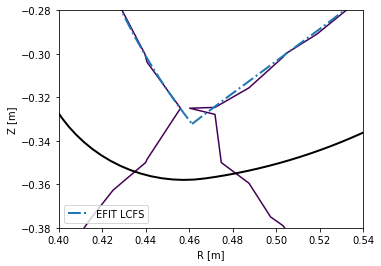

In [8]:
plt.figure()
ax = plt.gca()

#Limiter (stored in EFIT output)
ax.plot(eq_efit['rlim'], eq_efit['zlim'], color='k', lw=2)

#Magnetic surface defined by Psi = eq_efit['sibdry']
ax.contour(r_axis, z_axis, eq_efit['psi'].T, [eq_efit['sibdry']])

#Magnetic surface saved as the LCFS in EFIT output
ax.plot(eq_efit['rbdry'], eq_efit['zbdry'], 'C0-.', lw=2, label='EFIT LCFS')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')
plt.legend()
ax.set_xlim(0.4, 0.54)
ax.set_ylim(-0.38, -0.28)

PLEQUE, however, performs equilibrium interpolation that can easily produce the same plots in a much higher spatial resolution.

(-0.38, -0.28)

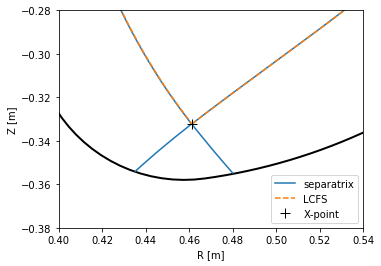

In [9]:
plt.figure()
ax = plt.gca()

#Limiter (accessed through the Equilibrium class)
eq.first_wall.plot(ls="-", color="k", lw=2)

#Separatrix, cropped to its part inside the first wall
inside_fw = eq.in_first_wall(eq.separatrix)
separatrix = eq.coordinates(R=eq.separatrix.R[inside_fw], Z=eq.separatrix.Z[inside_fw])
separatrix.plot(label='separatrix')

#LCFS (without strike points)
eq.lcfs.plot(color='C1', ls='--', label='LCFS')

#X-point
ax.plot(eq._x_point[0], eq._x_point[1], 'k+', markersize=10, label='X-point')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')
plt.legend()
ax.set_xlim(0.4, 0.54)
ax.set_ylim(-0.38, -0.28)


## PLEQUE vs raw reconstruction: $q$ profile

The safety factor $q$ can be defined as the number of toroidal turns a magnetic field line makes along its magnetic surface before it makes a full poloidal turn. Since the poloidal field is zero at the X-point, the magnetic field lines inside the separatrix are caught in an infinite toroidal loop at the X-point and $q \rightarrow +\infty$. (This is why the edge safety factor is given as $q_{95}$ at $\psi_N=0.95$. If it were given an $\psi_N = 1.00$, its value would diverge regardless of its profile shape.)

In this section we compare several methods of calculating $q$:

1. $q$ as calculated by the reconstruction itself (`q_efit`)
2. $q$ evaluated by `eq.q` (`q_eq`)
3. $q$ evaluated by `eq._flux_surface(psi_n).eval_q`
    - using the default, rectangle rule (`q1`)
    - using the trapezoidal rule (`q2`)
    - using the Simpson rule (`q3`)

Method 3 calculates the safety factor according to formula (5.35) in [Jardin, 2010: Computation Methods in Plasma Physics]:

$q(\psi) = \dfrac{gV'}{(2\pi)^2\Psi'}\langle R^{-2}\rangle$

where $V'$ is the differential volume and, in PLEQUE's notation, $g(\psi) \equiv F(\psi)$ and $\Psi \equiv \psi$ (and therefore $\Psi' \equiv d\Psi/d\psi = 1$). Furthermore, the surface average $\langle \cdot \rangle$ of an arbitrary function $a$ is defined as $\langle a \rangle = \frac{2\pi}{V'} \int_0^{2\pi} d\theta Ja$ where $J$ is the Jacobian. Putting everything together, one obtains the formula used by PLEQUE:

$q(\psi) = \dfrac{F(\psi)}{2\pi} \int_0^{2\pi} d\theta JR^{-2}$

where, based on the convention defined by COCOS, the factor $2\pi$ can be missing and $q$ may be either positive or negative. (In the default convention of EFIT, COCOS 3, $q$ is negative.) Finally, the integral can be calculated with three different methods: the rectangle rule (resulting in `q1`), the trapezoidal rule (resulting in `q2`) and the Simpson rule (resulting in `q3`).

Method 2 is based on method 3. The safety factor profile is calculated for 200 points in $\psi_N \in (0, 1)$ and interpolated with a spline. `eq.q` then invokes this spline to calculate $q$ at any given $\psi_N$.

In [10]:
#q taken directly from the reconstruction
q_efit = eq_efit['q']
q_efit = q_efit[:-1] #in some reconstructions, q is calculated up to psi_N=1
psi_efit = np.linspace(0, 1, len(q_efit), endpoint=False)
#psi_efit2 = np.linspace(0, 1, len(q_efit), endpoint=True)

#q stored in the Equilibrium class
coords = eq.coordinates(psi_n = np.linspace(0, 1, len(q_efit), endpoint=False))
psi_eq = coords.psi_n
q_eq = abs(eq.q(coords))

#q calculated by eq._flux_surface(Psi).eval_q
surf_psin = linspace(0.01, 1, len(q_efit), endpoint=False)
surfs = [eq._flux_surface(psi_n=psi_n)[0] for psi_n in surf_psin]
surf_psin = [np.mean(s.psi_n) for s in surfs]
q1 = abs(np.array([np.asscalar(s.eval_q) for s in surfs]))
q2 = abs(np.array([np.asscalar(s.get_eval_q('trapz')) for s in surfs]))
q3 = abs(np.array([np.asscalar(s.get_eval_q('simps')) for s in surfs]))

--- Generating q-splines ---
1%
11%
21%
31%
41%
51%
61%
71%
81%
91%


Notice the absolute value; this is required because $q<0$ in the convention used here.

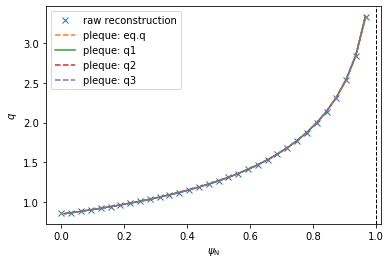

In [11]:
#q profile comparison
plt.figure()
plt.plot(psi_efit, q_efit, 'x', label='raw reconstruction')
#plt.plot(psi_efit2, q_efit, 'x', label='raw reconstruction')
plt.plot(psi_eq, q_eq, '--', label=r'pleque: eq.q')
plt.plot(surf_psin, q1, '-', label=r'pleque: q1')
plt.plot(surf_psin, q2, '--', label=r'pleque: q2')
plt.plot(surf_psin, q3, '--', label=r'pleque: q3')
plt.xlabel(r'$\psi_\mathrm{N}$')
plt.ylabel(r'$q$')
plt.axvline(1, ls='--', color='k', lw=1)
plt.legend()

Investigating the differences between the five $q$ profiles shows quite a good agreement. The profiles disagree slightly near $\psi_N \rightarrow 0$ since the safety factor is defined by a limit here. (Notice that, using method 3, the $\psi_N$ axis begins at 0.01 and not 0. This is because $q$ cannot be calculated by the formula above in $\psi_N=0$ and the algorithm fails.)

Text(0, 0.5, '$\\Delta q$')

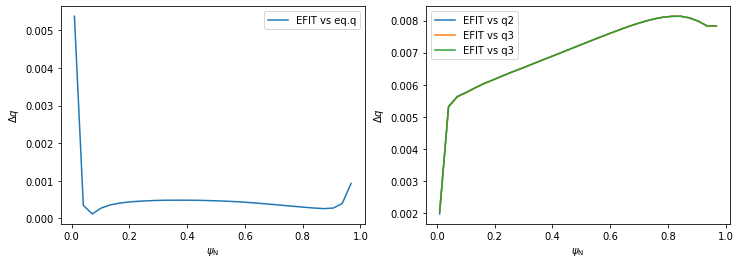

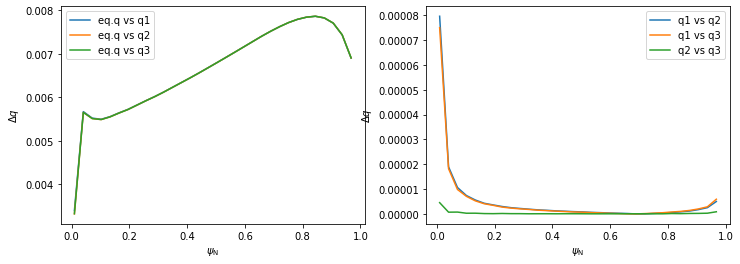

In [12]:
plt.figure(figsize=(12,4))

#EFIT vs eq.q
plt.subplot(121)
plt.plot(surf_psin, abs(q_eq-q_efit), label='EFIT vs eq.q')
plt.legend()
plt.xlabel(r'$\psi_\mathrm{N}$')
plt.ylabel(r'$\Delta q$')

#EFIT vs q1-q3
plt.subplot(122)
plt.plot(surf_psin, abs(q_efit-q1), label='EFIT vs q2')
plt.plot(surf_psin, abs(q_efit-q2), label='EFIT vs q3')
plt.plot(surf_psin, abs(q_efit-q3), label='EFIT vs q3')
plt.legend()
plt.xlabel(r'$\psi_\mathrm{N}$')
plt.ylabel(r'$\Delta q$')


plt.figure(figsize=(12,4))

#eq.q vs all the rest
plt.subplot(121)
plt.plot(surf_psin, abs(q_eq-q1), label='eq.q vs q1')
plt.plot(surf_psin, abs(q_eq-q2), label='eq.q vs q2')
plt.plot(surf_psin, abs(q_eq-q3), label='eq.q vs q3')
plt.legend()
plt.xlabel(r'$\psi_\mathrm{N}$')
plt.ylabel(r'$\Delta q$')

#q1 vs q2 vs q3
plt.subplot(122)
plt.plot(surf_psin, abs(q1-q2), label='q1 vs q2')
plt.plot(surf_psin, abs(q1-q3), label='q1 vs q3')
plt.plot(surf_psin, abs(q2-q3), label='q2 vs q3')
plt.legend()
plt.xlabel(r'$\psi_\mathrm{N}$')
plt.ylabel(r'$\Delta q$')

## Plotting 2D maps of various quantities
In this section PLEQUE is used to produce contour plots of the following quantities:

- poloidal magnetic field flux $\psi$
- toroidal magnetic field flux
- poloidal magnetic field $B_p$
- toroidal magnetic field $B_t$
- total magnetic field $|B|$
- total pressure $p$
- toroidal current density $j_\phi$
- poloidal current density $j_\theta$

. First, a general plotting function `plot_2d` is defined.

In [13]:
def plot_2d(R, Z, data, *args, title=None):
    
    #Define X and Y axis limits based on the vessel size
    rlim = [np.min(eq.first_wall.R), np.max(eq.first_wall.R)]
    zlim = [np.min(eq.first_wall.Z), np.max(eq.first_wall.Z)]
    size = rlim[1] - rlim[0]
    rlim[0] -= size / 12
    rlim[1] += size / 12
    size = zlim[1] - zlim[0]
    zlim[0] -= size / 12
    zlim[1] += size / 12
    
    #Set up the figure: set axis limits, draw LCFS and first wall, write labels
    ax = plt.gca()
    ax.set_xlim(rlim)
    ax.set_ylim(zlim)
    ax.plot(eq.lcfs.R, eq.lcfs.Z, color='k', ls='--', lw=2)
    ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-', lw=2)
    ax.set_xlabel('R [m]')
    ax.set_ylabel('Z [m]')
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)
        
    #Finally, plot the desired quantity
    cl = ax.contour(R, Z, data, *args)
        
    return cl

Now we set up an $[R,Z]$ grid where these quantities are evaluated and plot the quantities.

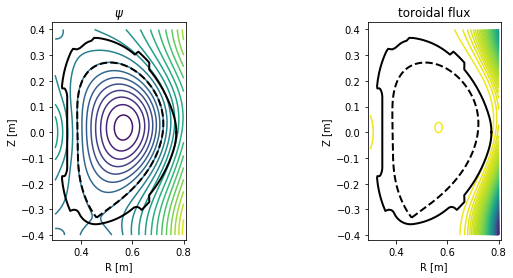

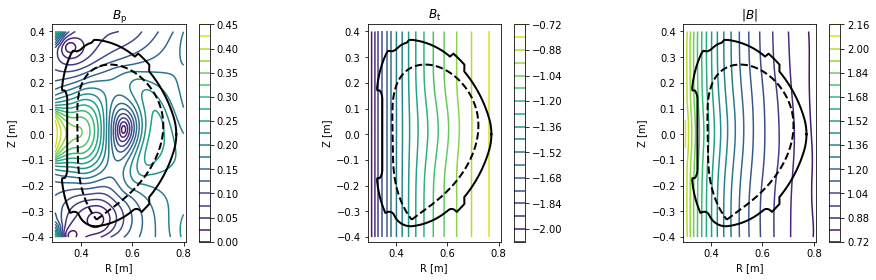

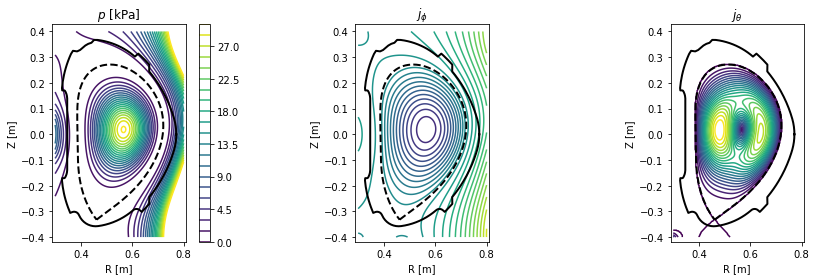

In [14]:
#Create an [R,Z] grid 200 by 300 points
grid = eq.grid((200,300), dim='size')

#Plot the poloidal flux and toroidal flux
plt.figure(figsize=(16,4))
plt.subplot(131)
plot_2d(grid.R, grid.Z, grid.psi, 20, title=r'$\psi$')
plt.subplot(132)
plot_2d(grid.R, grid.Z, eq.tor_flux(grid), 100, title='toroidal flux')

#Plot the poloidal magnetic field, toroidal magnetic field and the total magnetic field
plt.figure(figsize=(16,4))
plt.subplot(131)
cl = plot_2d(grid.R, grid.Z, eq.B_pol(grid), 20, title=r'$B_\mathrm{p}$')
plt.colorbar(cl)
plt.subplot(132)
cl = plot_2d(grid.R, grid.Z, eq.B_tor(grid), 20, title=r'$B_\mathrm{t}$')
plt.colorbar(cl)
plt.subplot(133)
cl = plot_2d(grid.R, grid.Z, eq.B_abs(grid), 20, title=r'$|B|$')
plt.colorbar(cl)

#Plot the total pressure, toroidal current density and poloidal current density
plt.figure(figsize=(16,4))
plt.subplot(131)
cl = plot_2d(grid.R, grid.Z, eq.pressure(grid)/1e3, np.linspace(0, 30, 21), title=r'$p$ [kPa]')
plt.colorbar(cl)
plt.subplot(132)
plot_2d(grid.R, grid.Z, eq.j_tor(grid), np.linspace(-5e6, 5e6, 30), title=r'$j_\phi$')
plt.subplot(133)
plot_2d(grid.R, grid.Z, eq.j_pol(grid),  np.linspace(0, 3e5, 21), title=r'$j_\theta$')

## Exploring flux surface properties

With the `eq._flux_surface(psi_n)` function, one may study individual flux surfaces. In this section, we plot the $\psi_N=0.8$ flux surface and calculate its safety factor $q$, length in the poloidal direction, total 3D area, volume and toroidal current density.

Safety factor: -1.94
Length: 1.16 m
Area: 0.0989 m^2
Volume: 0.339 m^3
Toroidal current density: -0.213 MA/m^2


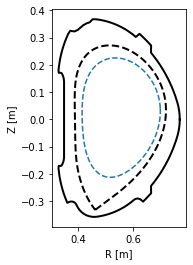

In [15]:
#Define the flux surface by its normalised poloidal flux
surf = eq._flux_surface(psi_n=0.8)[0]

#Plot the flux surface
plt.figure()
ax = gca()
ax.plot(eq.lcfs.R, eq.lcfs.Z, color='k', ls='--', lw=2)
ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-', lw=2)
surf.plot(ls='--')
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')

#Calculate several flux surface quantities
print('Safety factor: %.2f' % surf.eval_q[0])
print('Length: %.2f m' % surf.length)
print('Area: %.4f m^2' % surf.area)
print('Volume: %.3f m^3' % surf.volume)
print('Toroidal current density: %.3f MA/m^2' % (surf.tor_current/1e6))

## Profile mapping
In experiment one often encounters the need to compare profiles which were measured at various locations in the tokamak. In this section, we show how such a profile may be mapped onto an arbitrary location and to the outer midplane.

The profile is measured at the plasma top (in red) and mapped to the HFS (in violet) and the outer midplane (not shown).

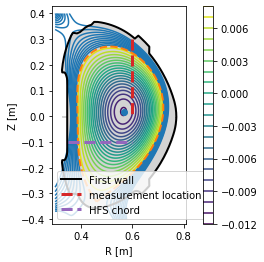

In [16]:
#Define the chords
N = 200 #number of datapoints in the profile
chord = eq.coordinates(R=0.6*np.ones(N), Z=np.linspace(0.3, 0., N))
chord_hfs = eq.coordinates(R=np.linspace(0.35, 0.6, 20), Z=-0.1*np.ones(20))

#Plot the chords
plt.figure()
eq._plot_overview()
chord.plot(lw=3, ls='--', color='C3', label='measurement location')
chord_hfs.plot(lw=3, ls='--', color='C4', label='HFS chord')
plt.legend(loc=3)

The profile shape is defined using the error function `erf`.

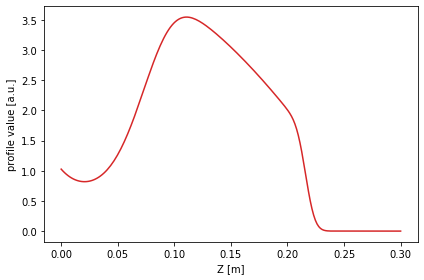

In [17]:
from scipy.special import erf

#Define the profile values
prof_func = lambda x, k1, xsep: k1/4 * (1 + erf((x-xsep)*20))*np.log((x+1)*1.2) - 4*np.exp(-(50*(x-1)**2))
profile = prof_func(1 - chord.psi_n, 10, 0.15)

#Plot the profile along the chord it was measured at
plt.figure()
plt.plot(chord.Z, profile, color='C3')
plt.xlabel('Z [m]')
plt.ylabel('profile value [a.u.]')
plt.tight_layout()

The profile is now converted into a flux function by `eq.fluxfuncs.add_flux_func()`. The flux function is a spline, and therefore it can be evaluated at any $\psi_N$ coordinate covered by the original chord. This will allow its mapping to any other coordinate.

In [18]:
eq.fluxfuncs.add_flux_func('test_profile', profile, chord, spline_smooth=0)

Passing an instance of the `Coordinates` class to the flux function will cause the function to evaluate the profile value along these coordinates. In the next figure the profile is mapped to the HFS cord.

Text(0, 0.5, 'profile value [a.u.]')

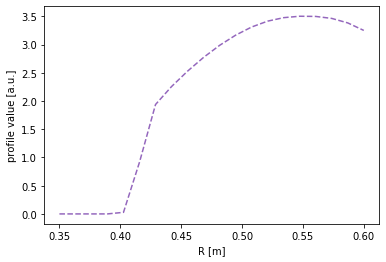

In [19]:
#Map the profile to the HFS cord
plt.figure()
plt.plot(chord_hfs.R, eq.fluxfuncs.test_profile(chord_hfs), '--', color='C4')
plt.xlabel('R [m]')
plt.ylabel('profile value [a.u.]')

For the outer midplane, no special chord need be specified. Every instance of the `Coordinates` class can automatically map its coordinates to the outer midplane. (Note that this doesn't require a flux function to be specified. The conversion is made in the coordinates only.)

Text(0, 0.5, 'profile value [a.u.]')

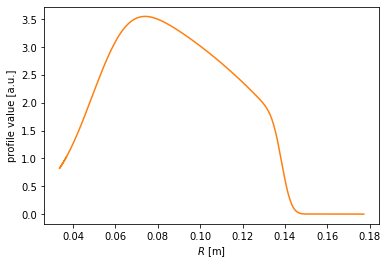

In [20]:
#Map the profile to the outer midplane
plt.figure()
plt.plot(chord.r_mid, profile, color='C1')
plt.xlabel(r'$R$ [m]')
plt.ylabel('profile value [a.u.]')

Finally, the profile may be drawn along the entire poloidal cross section.

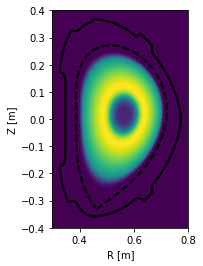

In [21]:
#Assuming poloidal symmetry, plot the profile in the poloidal cross section
plt.figure()
ax = gca()
ax.plot(eq.lcfs.R, eq.lcfs.Z, color='k', ls='--', lw=2)
ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-', lw=2)
grid = eq.grid()
ax.pcolormesh(grid.R, grid.Z, eq.fluxfuncs.test_profile(grid))
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')

## Detector line of sight visualisation

In this section, we demonstrate the flexibility of the `Coordinates` class on the example of detector line of sight visualisation. Suppose we have a pixel detector at the position $[X, Y, Z] = [1.2 \, \mathrm{m}, 0 \, \mathrm{m}, -0.1 \, \mathrm{m}]$.

In [22]:
# Define detector position
position = np.array((1.2, 0, -0.1))

The detector views the plasma mostly tangentially to the toroidal direction, but also sloping a little upward.

In [23]:
#Define the line of sigh direction
direction = np.array((-1, 0.6, 0.2))

#Norm the direction to unit length
direction /= np.linalg.norm(direction)

Now since the plasma geometry is curvilinear, the detector line of sight is not trivial. Luckily PLEQUE's `Coordinates` class can easily express its stored coordinates both in the cartesian $[X,Y,Z]$ and the cylindrical $[R,Z,\phi]$ coordinate systems. In the following line, 20 points along the detector line of sight are calculated in 3D.

In [24]:
# Calculate detector line of sight (LOS)
LOS = eq.coordinates(position + direction[np.newaxis,:] * np.linspace(0, 2.0, 20)[:, np.newaxis],
                     coord_type=('X', 'Y', 'Z')
                    )

To visualise the line of sight in top view $[X,Y]$ and poloidal cross-section view $[R,Z]$, we first define the limiter outline as viewed from the top. Then we proceed with the plotting.

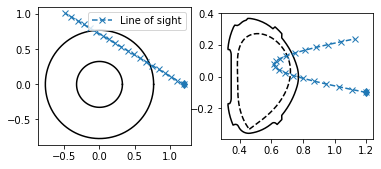

In [25]:
# Limiter outline viewed from the top
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

# Prepare figure
fig, axs = plt.subplots(1,2)

# Top view
ax = axs[0]
ax.plot(inner_lim.X, inner_lim.Y, 'k-')
ax.plot(outer_lim.X, outer_lim.Y, 'k-')
ax.plot(LOS.X, LOS.Y, 'x--', label='Line of sight')
ax.plot(position[0], position[1], 'd', color='C0')
ax.legend()
ax.set_aspect('equal')

# Poloidal cross-section view
ax = axs[1]
ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')
ax.plot(LOS.R, LOS.Z, 'x--')
ax.plot(LOS.R[0], position[2], 'd', color='C0')
ax.set_aspect('equal')

## Field line tracing

In this section, we show case field line tracing. First we define a set of five starting points, all located at the outer midplane ($Z=0$) with $R$ going from $0.55 \, \mathrm{m}$ (core) to $0.76\, \mathrm{m}$ (SOL).

In [26]:
# Define the starting points
N = 5
Rs = np.linspace(0.57, 0.76, N, endpoint=True)
Zs = np.zeros_like(Rs)

In [41]:
Rsep = 0.7189
Rs = Rsep + 0.001*np.array([0, 0.2, 0.5, 0.7, 1, 1.5, 2.5, 4, 6, 9, 15, 20])
Zs = np.zeros_like(Rs)

out = eq.trace_field_line(R=Rs, Z=Zs, direction=-1)
def integrate_length(field_line):
    L = 0
    fl_end = field_line.intersection(eq.first_wall, dim=2)
    ending_Z = -100 if fl_end is None else fl_end.Z
        #the coordinate line doesn't intersect the limiter
    for k in range(1, len(field_line.R)):
        if field_line.Z[k] < ending_Z:
            print('step %i/%i: encountered field line end' % (k,len(field_line.R)))
            break
        dX = field_line.X[k] - field_line.X[k-1]
        dY = field_line.Y[k] - field_line.Y[k-1]
        dZ = field_line.Z[k] - field_line.Z[k-1]
        L = L + np.sqrt(dX**2 + dY**2 + dZ**2)
    return L


>>> tracing from: 0.718900,0.000000,0.000000
>>> atol = 1e-06
>>> z-lim stopper is used
A termination event occurred., 2296
>>> tracing from: 0.719100,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 1664
>>> tracing from: 0.719400,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 1504
>>> tracing from: 0.719600,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 1426
>>> tracing from: 0.719900,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 1305
>>> tracing from: 0.720400,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 1226
>>> tracing from: 0.721400,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 1093
>>> tracing from: 0.722900,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 1006
>>> tracing from: 0.724900,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 917
>>> tracing from: 0.727900,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 

step 1564/1600: encountered field line end
step 1166/1203: encountered field line end
step 956/995: encountered field line end
step 877/917: encountered field line end
step 794/835: encountered field line end
step 704/747: encountered field line end
step 597/644: encountered field line end
step 508/558: encountered field line end
step 437/492: encountered field line end
step 371/433: encountered field line end
step 293/368: encountered field line end
step 249/335: encountered field line end


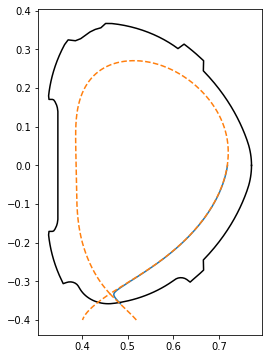

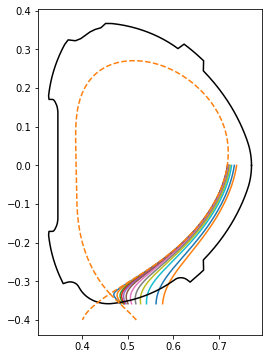

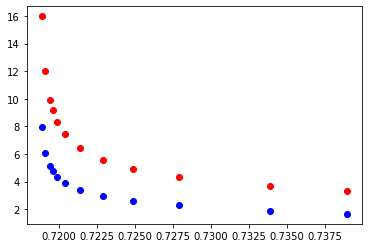

In [39]:

plt.figure(figsize=(4,6))
plt.plot(out[0].R, out[0].Z)
plt.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
plt.plot(eq.separatrix.R, eq.separatrix.Z, 'C1--')

plt.figure(figsize=(4,6))
for fl in out:
    plt.plot(fl.R, fl.Z)
plt.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
plt.plot(eq.separatrix.R, eq.separatrix.Z, 'C1--')

plt.figure()
plt.plot(Rs, [integrate_length(out[k]) for k in range(len(Rs))], 'bo')
plt.plot(Rs, [out[k].length for k in range(len(Rs))], 'ro')

In [ ]:
point = out[0].intersection(eq.first_wall, dim=2)
plt.figure(figsize=(4,6))
plt.plot(out[0].R, out[0].Z)
plt.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
plt.plot(eq.separatrix.R, eq.separatrix.Z, 'C1--')
plt.plot(point.R, point.Z, 'bo')
plt.xlim(0.47, 0.5)
plt.ylim(-0.36, -0.35)

fl = eq.coordinates(R=2*np.ones(50), Z=np.zeros(50), phi=np.linspace(0, 2*np.pi, 50))
print(fl.length)
integrate_length(fl)

In [30]:
out[0].intersection

<bound method Coordinates.intersection of <pleque.core.coordinates.Coordinates object at 0x7f5196786f90>>

Next, the field lines beginning at these points are traced. The default tracing direction is `direction=1`, that is, following the direction of the toroidal magnetic field.

In [31]:
traces = eq.trace_field_line(R=Rs, Z=Zs)

>>> tracing from: 0.718900,0.000000,0.000000
>>> atol = 1e-06
>>> z-lim stopper is used
A termination event occurred., 4709
>>> tracing from: 0.719100,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 4372
>>> tracing from: 0.719400,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 4143
>>> tracing from: 0.719600,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 3906
>>> tracing from: 0.719900,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 3875
>>> tracing from: 0.720400,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 3863
>>> tracing from: 0.721400,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 3920
>>> tracing from: 0.722900,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 4016
>>> tracing from: 0.724900,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred., 4086
>>> tracing from: 0.727900,0.000000,0.000000
>>> atol = 1e-06
A termination event occurred.,

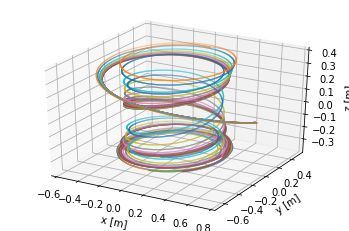

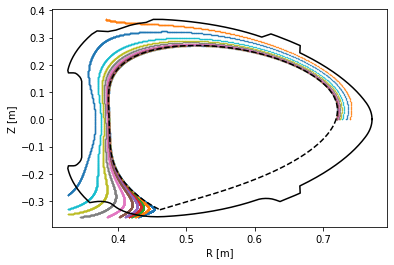

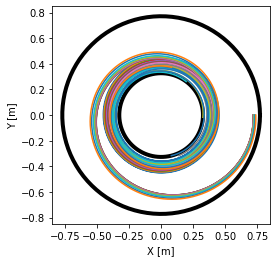

In [32]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

for fl in traces:
    ax.scatter(fl.X, fl.Y, fl.Z, s=0.3, marker='.')

#ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')



fig = plt.figure()
ax = fig.gca()

ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')

for fl in traces:
    ax.scatter(fl.R, fl.Z, s=0.3, marker='.')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
#ax.set_aspect('equal')


fig = plt.figure()
ax = fig.gca()

# Let's define limiters: 
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

ax.plot(inner_lim.X, inner_lim.Y, 'k-', lw=4)
ax.plot(outer_lim.X, outer_lim.Y, 'k-', lw=4)

for fl in traces:
    ax.plot(fl.X, fl.Y)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_aspect('equal')


NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

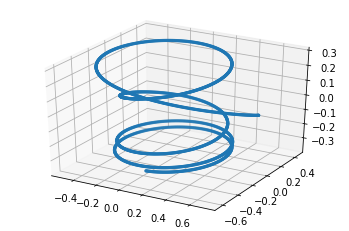

In [33]:
fig = plt.figure()
ax = fig.gca(projection='3d')

fl = traces[2]
ax.scatter(fl.X, fl.Y, fl.Z, marker='.')

ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

save_it(machine+'_tracing_1_3d', 1)

fig = plt.figure()
ax = fig.gca()

ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')


ax.scatter(fl.R, fl.Z, s=3, marker='.')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')

save_it(machine+'_tracing_1_rz', 1)

fig = plt.figure()
ax = fig.gca()

# Let's define limiters: 
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

ax.plot(inner_lim.X, inner_lim.Y, 'k-', lw=4)
ax.plot(outer_lim.X, outer_lim.Y, 'k-', lw=4)


ax.plot(fl.X, fl.Y)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_aspect('equal')

save_it(machine+'_tracing_1_xy', 1)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

fl = traces[-2]
ax.scatter(fl.X, fl.Y, fl.Z, marker='.')

ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

save_it(machine+'_tracing_1_3d', 2)

fig = plt.figure()
ax = fig.gca()

ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')


ax.scatter(fl.R, fl.Z, s=3, marker='.')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')


save_it(machine+'_tracing_1_rz', 2)
fig = plt.figure()
ax = fig.gca()

# Let's define limiters: 
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

ax.plot(inner_lim.X, inner_lim.Y, 'k-', lw=4)
ax.plot(outer_lim.X, outer_lim.Y, 'k-', lw=4)


ax.plot(fl.X, fl.Y)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_aspect('equal')

save_it(machine+'_tracing_1_xy', 2)

In [ ]:
eq.fluxfuncs.add_flux_func('test_prof', chord_prof, chord1, spline_smooth=0)
#plt.plot(chord1.Z, eq.fluxfuncs.test_prof(chord1), '--', color='C3')

## Straight field lines

In [ ]:
from scipy.optimize import minimize_scalar, brentq

#eq = load_testing_equilibrium(2)
#plt.figure()
#eq._plot_overview()

# todo: here is some ugly bug! Try to reslove it as soon as possible
#surf = eq._flux_surface(psi_n = 0.8)[0]

#surf.straight_fieldline_theta

psi_onq = brentq(lambda psi_n: np.abs(eq.q(psi_n)) - 5/3, 0, 0.95)
print(r'$\psi$ on q: {:.3f}'.format(psi_onq))
surf = eq._flux_surface(psi_n = psi_onq)[0]

In [ ]:
from scipy.interpolate import CubicSpline

theta = np.mod(surf.theta, 2*np.pi)
theta_star = surf.straight_fieldline_theta

asort = np.argsort(theta)
#should be smothed 
theta = theta[asort][2::4]
theta_star = theta_star[asort][2::4]

plt.figure()
plt.plot(np.diff(theta))
plt.plot(ma.masked_greater(np.diff(theta), 0))

plt.figure()
plt.plot(theta)

thstar_spl = CubicSpline(theta, theta_star, extrapolate='periodic')




plt.figure()
thh = np.linspace(0, 6*np.pi,100)
plt.plot(thh, thstar_spl(thh), 'x-')
plt.plot(thh, surf._theta2thetastar_spl(thh), 'x-')



In [ ]:
traces = eq.trace_field_line(r=eq.coordinates(psi_onq).r_mid[0], theta=0)
tr = traces[0]
print('tr:  {:3f},{:3f},{:3f} -> {:3f},{:3f},{:3f}'.format( tr.R[0],  tr.Z[0],  tr.phi[0],  tr.R[-1],  tr.Z[-2],  tr.phi[-1]))

traces2 = eq.trace_field_line(tr.R[-1], tr.Z[-1], tr.phi[-1])
tr2 = traces2[0]
print('tr2: {:3f},{:3f},{:3f} -> {:3f},{:3f},{:3f}'.format(tr2.R[0], tr2.Z[0], tr2.phi[0], tr2.R[-1], tr2.Z[-2], tr2.phi[-1]))

traces3 = eq.trace_field_line(tr2.R[-1], tr2.Z[-1], tr2.phi[-1])
tr3 = traces3[0]
print('tr3: {:3f},{:3f},{:3f} -> {:3f},{:3f},{:3f}'.format(tr3.R[0], tr3.Z[0], tr3.phi[0], tr3.R[-1], tr3.Z[-2], tr3.phi[-1]))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

fl = tr
ax.scatter( tr.X,  fl.Y,  tr.Z, marker='.')
ax.scatter(tr2.X, tr2.Y, tr2.Z, marker='.')
ax.scatter(tr3.X, tr3.Y, tr3.Z, marker='.')

ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

save_it('straight_fl_3d')


fig = plt.figure()
ax = fig.gca()

ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')

ax.scatter(tr.R, tr.Z, s=2, marker='.')
ax.scatter(tr2.R, tr2.Z, s=2, marker='.')
ax.scatter(tr3.R, tr3.Z, s=2, marker='.')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')

save_it('straight_fl_rz')

fig = plt.figure()
ax = fig.gca()

# Let's define limiters: 
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

ax.plot(inner_lim.X, inner_lim.Y, 'k-', lw=4)
ax.plot(outer_lim.X, outer_lim.Y, 'k-', lw=4)


ax.plot(tr.X, tr.Y)
ax.plot(tr2.X, tr2.Y)
ax.plot(tr3.X, tr3.Y)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_aspect('equal')

save_it('straight_fl_xy')

plt.figure()
ax = plt.gca()
ax.plot(surf.psi)
ax.plot(tr.psi)

In [ ]:
from numpy import ma
plt.figure()
plt.axhline(0, ls='--', color='k')
plt.plot(surf.theta, np.mod(np.pi+surf.straight_fieldline_theta, 2*np.pi)-np.pi)
plt.plot(np.mod(surf.theta, 2*np.pi), surf.straight_fieldline_theta)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\theta_\mathrm{sl}$')


plt.ylabel(r'$\theta_\mathrm{sl}$')

plt.figure()
plt.plot(surf.theta)
plt.plot(np.mod(np.pi+surf.straight_fieldline_theta, 2*np.pi)-np.pi)

trs = [tr, tr2, tr3]

f1 = plt.figure()
ax_fl = plt.gca()

f2 = plt.figure()
ax_sfl = plt.gca()

f3 = plt.figure()
ax3 = plt.gca()

for t in trs:
    theta_tr = np.mod(t.theta, 2*np.pi)
    theta_sfl_tr = thstar_spl(theta_tr)
    phi_tr = np.mod(t.phi, 2*np.pi)
    
    
    theta_tr = ma.masked_greater(theta_tr, 2*np.pi-1e-2)
    theta_tr = ma.masked_less(theta_tr, 1e-2)
    
    theta_sfl_tr = ma.masked_greater(theta_sfl_tr, 2*np.pi-1e-2)
    theta_sfl_tr = ma.masked_less(theta_sfl_tr, 1e-2)
    
    phi_tr = ma.masked_greater(phi_tr, 2*np.pi-1e-2)
    phi_tr = ma.masked_less(phi_tr, 1e-2)

    ax_fl.plot(phi_tr, theta_tr, 'k-')
    ax_sfl.plot(phi_tr, theta_sfl_tr, 'k-')
    
    ax3.plot(diff(theta_sfl_tr))
    
ax_fl.set_xlabel(r'$\phi$')
ax_fl.set_ylabel(r'$\theta$')
ax_fl.set_title(r'$q = 5/3$')
plt.figure(f1.number)
save_it('straight_fl_not')

ax_sfl.set_xlabel(r'$\phi$')
ax_sfl.set_ylabel(r'$\theta^*$')
ax_sfl.set_title(r'$q = 5/3$')
plt.figure(f2.number)
save_it('straight_fl')




In [ ]:
psi_n = np.linspace(0, 1, 1000)[1:-1]
surfs = [eq._flux_surface(pn)[0] for pn in psi_n]

psi_n2 = np.linspace(0, 1, 7)[1:]
surfs2 = [eq._flux_surface(pn)[0] for pn in psi_n2]



In [ ]:
f1 = plt.figure()
ax = plt.gca()
f2 = plt.figure()
ax2 = plt.gca()



#eq.first_wall.plot(ax = ax, color='k', ls='--', lw=3)
eq.lcfs.plot(ax = ax, color = 'k', ls = '-', lw=3)
#eq.first_wall.plot(ax = ax2, color='k', ls='--', lw=3)
eq.lcfs.plot(ax = ax2, color = 'k', ls = '-', lw=3)


for s in surfs2:
    s.plot(ax = ax, color='k', lw = 1)
    s.plot(ax = ax2, color='k', lw = 1)


thetas = np.linspace(0, 2*np.pi, 13, endpoint=False)

for th in thetas:
    # this is so ugly has to implemented it better as soon as possible (!)
    print(th)
    c = eq.coordinates(r = np.linspace(0, 0.4, 300), theta = np.ones(300)*th)
    amin = np.argmin(np.abs(c.psi_n - 1))
    r_lcfs = c.r[amin]
        
    psi_n = np.array([np.mean(s.psi_n) for s in surfs])    
    c = eq.coordinates(r = np.linspace(0, r_lcfs, len(psi_n)), theta=np.ones(len(psi_n))*th)
    c.plot(ax = ax, color='k', lw=1)
    
    idxs = [np.argmin(np.abs(s.straight_fieldline_theta - th)) for s in surfs]
    rs = [s.r[i] for s,i in zip(surfs,idxs)]
    rs = np.hstack((0, rs))
    thetas  = [s.theta[i] for s,i in zip(surfs,idxs)]
    thetas = np.hstack((0, thetas))
    c = eq.coordinates(r = rs, theta = thetas)
    c.plot(ax = ax2, color = 'k', lw=1)
    
    
ax.set_aspect('equal')
ax2.set_aspect('equal')

ax.set_title(r'$\theta$')
ax2.set_title(r'$\theta^*$')

plt.figure(f1.number)
save_it('straight_fieldline_grid_not')
plt.figure(f2.number)
save_it('straight_fieldline_grid')